In [75]:
import pyhrv, hrvanalysis


def calc_features(intervals, samplingRate, pyHRV=True):
    
    features = {}
    
    if pyHRV:
        rr_features = pyhrv.time_domain.nni_parameters(nni=intervals)
        hr_features = pyhrv.time_domain.hr_parameters(nni=intervals)
        rmssd = pyhrv.time_domain.rmssd(nni=intervals)
        freq_features = pyhrv.frequency_domain.welch_psd(nni=intervals, show=False, mode='dev')
        
        features.update({'nni_mean': rr_features['nni_mean'], 'hr_mean': hr_features['hr_mean'], 
                        'hr_std': hr_features['hr_std'], 'rmssd': rmssd['rmssd'],
                        'lf': freq_features[0]['fft_abs'][1], 'hf': freq_features[0]['fft_abs'][2],
                        'LF/HF ratio': freq_features[0]['fft_ratio']})     
 
    else:
        time_features = hrvanalysis.get_time_domain_features(intervals)
        freq_features = hrvanalysis.get_frequency_domain_features(intervals)

        features.update({'nni_mean': time_features['mean_nni'], 'hr_mean': time_features['mean_hr'], 
                        'hr_std': time_features['std_hr'], 'rmssd': time_features['rmssd'],
                        'lf': freq_features['lf'], 'hf': freq_features['hf'],
                        'LF/HF ratio': freq_features['lf_hf_ratio']})
        
    return features
        

In [76]:
import wfdb
from ecgdetectors import Detectors

sig, fields = wfdb.rdsamp("Sensor data/100")
ecg_30min = sig[:, 0]
sr = fields["fs"]

det = Detectors(sr)
pyecg_peaks = det.swt_detector(ecg_30min)
pyecg_intervals = [4 * (pyecg_peaks[i] - pyecg_peaks[i-1]) for i in range(1,len(pyecg_peaks))]


In [77]:
pyhrv_feat = calc_features(intervals=pyecg_intervals, samplingRate=sr, pyHRV=False)

In [315]:
import time
from bitalino import BITalino
import biosignalsnotebooks as bsnb

macAddress = "/dev/tty.BITalino-DevB"

# This example will collect data for 60 sec.
running_time = 10
    
acqChannels = [1]
samplingRate = 100
nSamples = 100

# Calculate features every 10 seconds
feature_interval = 10
feature_time = 0

det = Detectors(samplingRate)

# Connect to BITalino
device = BITalino(macAddress)

# Start Acquisition
device.start(samplingRate, acqChannels)

start = time.time()
end = time.time()

data = []
features = []

try:
    while (end - start) < running_time:
        new_samples = device.read(nSamples)
        new_signal = [s[-2] for s in new_samples]
    
        data += new_signal
        
        if feature_time > 0:
            data = data[-samplingRate*5*60:]

            peaks = det.swt_detector(data)
            intervals = [4 * (peaks[i] - peaks[i-1]) for i in range(1,len(peaks))]

            new_features = calc_features(intervals=intervals, samplingRate=samplingRate)
            features += new_features
            print(new_features)
            
            feature_time = 0
        
        feature_time += time.time() - end
        end = time.time()

except:
    print("Data processing crashed")

finally:   
    # Stop acquisition
    device.stop()
    
    # Close connection
    device.close()

Data processing crashed


In [331]:
macAddress = "/dev/tty.BITalino-DevB"

# This example will collect data for 60 sec.
running_time = 20 * 60
    
acqChannels = [1]
samplingRate = 100
nSamples = 100

# Calculate features every 10 seconds
feature_interval = 10
feature_time = 0

det = Detectors(samplingRate)

# Connect to BITalino
device = BITalino(macAddress)

# Start Acquisition
device.start(samplingRate, acqChannels)

start = time.time()
end = time.time()

inflating = False
inflating_start_time = time.time()

data = []
features = []
trends = {}

while (end - start) < running_time:
        start_loop = time.time()
        
        new_samples = device.read(nSamples)
        new_signal = [s[-1] for s in new_samples]
    
        data += new_signal
        
        if inflating and (time.time() - inflating_start_time) > 5:
            client.send_message("/actuator/1/inflate", -50.0)
            print("deflating")
            inflating = False
        
        if feature_time > feature_interval:
            data = data[-samplingRate*5*60:]
            #print(data[:5])
            
            peaks = det.swt_detector(data)
            intervals = [(1000 / samplingRate) * (peaks[i] - peaks[i-1]) for i in range(1,len(peaks))]
            
            print(len(intervals))
            new_features = calc_features(intervals=intervals, samplingRate=samplingRate)
            features.append(new_features)
            print(new_features)
            
            if (end - start) > 1 * 60:
                
                for key in features[0].keys():
                    trends[key] = detect_trend([f[key] for f in features])
        
                if trends["rmssd"] < 0:
                    print("detected increase in anxiety")
                    
                if not inflating:
                    client.send_message("/actuator/1/inflate", 50.0)
                    print("inflating")
                    inflating_start_time = time.time()
                    inflating = True
                    
            
            feature_time = 0
        
        
        feature_time += time.time() - end
        end = time.time()

        end_loop = time.time()
        print("Execution time of loop: ", end_loop - start_loop)
      
    
device.stop()
device.close()

Execution time of loop:  2.0435101985931396
Execution time of loop:  0.9806599617004395
Execution time of loop:  1.2654359340667725
Execution time of loop:  1.0006349086761475
Execution time of loop:  0.9148080348968506
Execution time of loop:  0.9032497406005859
Execution time of loop:  1.031449794769287
Execution time of loop:  0.8354768753051758
Execution time of loop:  0.8834528923034668
Execution time of loop:  0.5663201808929443
11
{'nni_mean': 961.8181818181819, 'hr_mean': 63.09979500366192, 'hr_std': 7.055050980371769, 'rmssd': 105.64090116995405, 'lf': 2541.5862961479097, 'hf': 4975.489021211901, 'LF/HF ratio': 0.5108214057577892}
Execution time of loop:  0.8041689395904541
Execution time of loop:  0.9568009376525879
Execution time of loop:  0.9381928443908691
Execution time of loop:  1.0728909969329834
Execution time of loop:  0.9693818092346191
Execution time of loop:  0.9558000564575195
Execution time of loop:  0.9886348247528076
Execution time of loop:  1.0372722148895264


KeyboardInterrupt: 

In [269]:
import wfdb

sig, fields = wfdb.rdsamp("Sensor data/100")
ecg_30min = sig[:, 0]  

sr = fields["fs"]
window_length = 5 * 60 * sr

features_mit = []

print(int((len(ecg_30min) - window_length) / (sr * 30)) + 1)

for i in range(0, int((len(ecg_30min) - window_length) / (sr * 30)) + 1 ):
    ecg_window = ecg_30min[i*sr:i*sr+window_length]
    
    peaks_mit = det.swt_detector(ecg_window)
    intervals_mit = [(1000 / sr) * (peaks_mit[i] - peaks_mit[i-1]) for i in range(1,len(peaks_mit))]
    
    new_features = calc_features(intervals=intervals_mit, samplingRate=sr)
    features_mit.append(new_features)
        
    if i%5 == 0:
        print(i, " windows calculated")

51
0  windows calculated
5  windows calculated
10  windows calculated
15  windows calculated
20  windows calculated
25  windows calculated
30  windows calculated
35  windows calculated
40  windows calculated
45  windows calculated
50  windows calculated


In [143]:
from pythonosc.udp_client import SimpleUDPClient

ip = "192.168.0.106"
port = 32000

client = SimpleUDPClient(ip, port)  # Create client

client.send_message("/actuator/1/inflate", -32.0)   # Send float message between -100 and 100


In [332]:
device.stop()
device.close()

In [324]:
client.send_message("/actuator/1/inflate", -100.0)
time.sleep(7)
client.send_message("/actuator/1/inflate", 0.0)

In [210]:
start = time.time()
running_time = 20

while (time.time() - start) < running_time:
    client.send_message("/actuator/1/inflate", 100.0)
    time.sleep(2)
    client.send_message("/actuator/1/inflate", -100.0)
    time.sleep(2)

KeyboardInterrupt: 

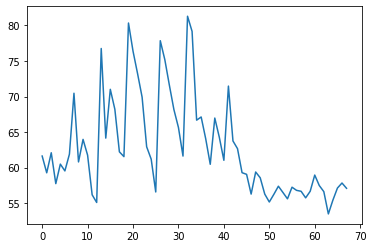

In [216]:
plt.figure()
plt.plot([f['hr_mean'] for f in features[45:]])
plt.show()

In [256]:
hr_means = [f['hr_mean'] for f in features]

hr_avg = sum(hr_means) / len(hr_means)

In [257]:
hr_stds = [f['hr_std'] for f in features]

hr_std_avg = sum(hr_stds) / len(hr_stds)

In [226]:
[x for x in hr_means if x > hr_avg + 0.5 * hr_std_avg]

[80.3421186274658, 81.29450876833754, 79.1637841030749]

In [253]:
def detect_trend(data):
    size = np.arange(0,len(data))
    data_array = np.array(data)
    trend = np.polyfit(size, data_array, 1)
    return trend[0]

In [345]:
detect_trend(feats)

array([-6.85843803])

In [277]:
trends = {}

for key in features[0].keys():
    print(key, ":", detect_trend([f[key] for f in features]))
    trends[key] = detect_trend([f[key] for f in features])

nni_mean : -7.644730482434067
hr_mean : -0.44069900647379484
hr_std : -0.36003244535891576
rmssd : -38.82116908506565
lf : -557923.761604315
hf : -24541.307403342915
LF/HF ratio : -1.2319001797023528


In [333]:
client.send_message("/actuator/1/inflate", 0.0)

In [336]:
peaks = det.swt_detector(data)
intervals = [(1000 / samplingRate) * (peaks[i] - peaks[i-1]) for i in range(1,len(peaks))]
            
print(len(intervals))
features = calc_features(intervals=intervals, samplingRate=samplingRate)



97


In [337]:
features

{'nni_mean': 973.7113402061856,
 'hr_mean': 61.9723069826777,
 'hr_std': 4.774807399845343,
 'rmssd': 83.52270150484038,
 'lf': 1194.157581601895,
 'hf': 1751.4443405107475,
 'LF/HF ratio': 0.6818130350940302}

In [344]:
feats = []

for i in range(0,9):
    feats.append(pyhrv.time_domain.rmssd(nni=intervals[i * 10: i * 10 + 10]))